In [1]:

!pip install tqdm

In [2]:
import numpy as np
import pandas as pd
import os
import time
import copy
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data as data_utils
from torchvision import datasets, models, transforms

from sklearn.model_selection import train_test_split

from efficientnet_pytorch import EfficientNet

# For image-keypoints data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [3]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value) 
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars\n
        torch.backends.cudnn.deterministic = True  #needed\n
        torch.backends.cudnn.benchmark = False

seed = 42
random_seed(seed,True)

In [4]:
train_dir = os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open","train_imgs")
num_classes = 48
batch_size = 3
num_epochs = 200
num_splits = 10
num_earlystop = 10
input_w_crop = 1080
input_h_crop = 1080
input_w_resize = 800
input_h_resize = 450
learning_rate = 0.01
feature_extract = False

In [5]:
df = pd.read_csv(os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open","train_df.csv"))
df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,...,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,...,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,...,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,...,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,...,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102


In [6]:
imgs = df.iloc[:, 0].to_numpy()
motions = df.iloc[:, 1:]
columns = motions.columns.to_list()[::2]
class_labels = [label.replace('_x', '').replace('_y', '') for label in columns]
keypoints = []
for motion in motions.to_numpy():
    a_keypoints = []
    for i in range(0, motion.shape[0], 2):
        a_keypoints.append((float(motion[i]), float(motion[i+1])))
    keypoints.append(a_keypoints)
keypoints = np.array(keypoints)

In [7]:
def train_model(model, dataloaders, criterion, optimizer, earlystop=0, num_epochs=25, is_inception=False):
    since = time.time()
    
    val_acc_history = []
    val_loss_history = []
    earlystop_value = 0

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0
    best_loss = 999999999
    
    for epoch in range(num_epochs):
        epoch_since = time.time()
        if earlystop and earlystop_value >= earlystop:
            break

        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        #print('outputs.shape, aux_outputs shape : ', outputs.shape, aux_outputs.shape)
                        loss1 = criterion(outputs.float(), labels.float())
                        loss2 = criterion(aux_outputs.float(), labels.float())
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        #print('output shape : ', outputs.shape)
                        #print(outputs)
                        loss = criterion(outputs.float(), labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # for regression
                running_corrects += torch.sum(outputs == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            epoch_time_elapsed = time.time() - epoch_since
            print('{} ({}) Loss: {:.4f} Acc: {:.4f} Elapsed time: {:.0f}m {:.0f}s'.format(
                phase, len(dataloaders[phase].dataset), epoch_loss, epoch_acc, epoch_time_elapsed // 60, epoch_time_elapsed % 60))
#             neptune.log_metric(f'{phase}_loss', epoch_loss)
#             neptune.log_metric(f'{phase}_acc', epoch_acc)
            
            # deep copy the model
            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    earlystop_value = 0
                else:
                    earlystop_value += 1
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Training and Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation Acc: {:4f}\n'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, {'acc': val_acc_history, 'loss': val_loss_history}

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = True

In [9]:
model_name = 'efficientnet'
model_ver = 'b5'
def initialize_model(model_name, model_ver, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    # variables is model specific.
#     model_ft = getattr(models, f'{model_name}{model_ver}')(pretrained=use_pretrained)
    model = EfficientNet.from_pretrained('efficientnet-b5')
    set_parameter_requires_grad(model, feature_extract)
    num_ftrs = model._fc.in_features
    model._fc = nn.Linear(num_ftrs, num_classes)
    #print(model)

    return model

# Initialize the model for this run
model_ft = initialize_model(model_name, model_ver, num_classes, feature_extract, use_pretrained=True)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Print the model we just instantiated
print(model_ft)

Loaded pretrained weights for efficientnet-b5
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2

In [10]:
A_transforms = {
    'train':
        A.Compose([
            #A.augmentations.CenterCrop(input_h_crop, input_w_crop, always_apply = True),
            A.Resize(input_h_resize, input_w_resize, always_apply=True),
#             A.OneOf([A.HorizontalFlip(p=1),
#                      A.RandomRotate90(p=1),
#                      A.VerticalFlip(p=1)            
#             ], p=0.5),
            A.augmentations.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True, angle_in_degrees=True)),
    
    'val':
        A.Compose([
            #A.augmentations.CenterCrop(input_h_crop, input_w_crop, always_apply = True),
            A.Resize(input_h_resize, input_w_resize, always_apply=True),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True, angle_in_degrees=True)),
    
    'test':
        A.Compose([
            #A.augmentations.CenterCrop(input_h_crop, input_w_crop, always_apply = True),
            A.Resize(input_h_resize, input_w_resize, always_apply=True),
            #A.augmentations.CenterCrop(input_h, input_w, always_apply = True),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
}

In [11]:
class Dataset(data_utils.Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, keypoints, phase, class_labels=None, data_transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.keypoints = keypoints
        self.phase = phase
        self.class_labels = class_labels
        self.data_transforms = data_transforms

    def __getitem__(self, idx):
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))
        keypoints = self.keypoints[idx]
    
        if self.data_transforms:
            augmented = self.data_transforms[self.phase](image=img, keypoints=keypoints, class_labels=self.class_labels)
            img = augmented['image']
            keypoints = augmented['keypoints']
        keypoints = np.array(keypoints).flatten()

        return img, keypoints
    
    def __len__(self):
        return len(self.imgs)

In [12]:
criterion = nn.MSELoss()

since = time.time()
X_train, X_val, y_train, y_val = train_test_split(imgs, keypoints, test_size=1/num_splits, random_state=42)
train_data = Dataset(train_dir, X_train, y_train, data_transforms=A_transforms, class_labels=class_labels, phase='train')
val_data = Dataset(train_dir, X_val, y_val, data_transforms=A_transforms, class_labels=class_labels, phase='val')
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = data_utils.DataLoader(val_data, batch_size=batch_size, shuffle=False)
dataloaders = {'train': train_loader, 'val': val_loader}

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

# Train and evaluate
model_ft, hists = train_model(
    model_ft, dataloaders, criterion, optimizer_ft,
    num_epochs=num_epochs,  is_inception=(model_name=="inception"))
weight_path = os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open", f"baseline_{model_name}_{model_ver}_0312.pth")
torch.save(model_ft.state_dict(), weight_path)
time_elapsed = time.time() - since
print('Elapsed time: {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

Epoch 1/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:27,  5.05it/s]

train (3775) Loss: 5367.9477 Acc: 0.0000 Elapsed time: 10m 22s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 3377.5237 Acc: 0.0000 Elapsed time: 10m 50s

Epoch 2/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 3110.3582 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 3227.9741 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 3/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.25it/s]

train (3775) Loss: 2302.2838 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 2046.4457 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 4/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 1843.6277 Acc: 0.0003 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 1833.3142 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 5/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 1626.5876 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 1318.4991 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 6/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.22it/s]

train (3775) Loss: 1429.2750 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 1936.0831 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 7/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.25it/s]

train (3775) Loss: 1296.3886 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 973.2809 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 8/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 1162.3327 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 971.6769 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 9/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 1046.8879 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 1009.5972 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 10/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.22it/s]

train (3775) Loss: 976.0848 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 954.8159 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 11/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 887.6022 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 777.1978 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 12/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.25it/s]

train (3775) Loss: 805.4395 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 692.8689 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 13/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 754.3254 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 711.5494 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 14/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 718.5631 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 712.4978 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 15/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 660.7475 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 482.4562 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 16/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 597.7723 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 888.3014 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 17/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 565.0961 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 548.3221 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 18/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 529.4122 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 436.8768 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 19/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 502.4117 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 520.1451 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 20/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 481.6467 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 337.7154 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 21/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 464.7814 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 412.1826 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 22/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 451.2504 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 340.4874 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 23/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 434.7446 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 318.8739 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 24/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 417.1106 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 291.4875 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 25/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 412.8294 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 282.7486 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 26/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.23it/s]

train (3775) Loss: 393.0289 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 311.2646 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 27/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.24it/s]

train (3775) Loss: 389.5362 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 286.9418 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 28/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 378.1204 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 256.5607 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 29/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.24it/s]

train (3775) Loss: 363.6258 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 272.5150 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 30/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.23it/s]

train (3775) Loss: 361.5321 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 453.7874 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 31/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 353.4904 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 253.9340 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 32/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 348.1946 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 252.8188 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 33/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 345.6708 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 495.6628 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 34/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 328.7136 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 222.7213 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 35/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 321.4795 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 243.7767 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 36/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.24it/s]

train (3775) Loss: 315.6563 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 273.0110 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 37/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 308.3885 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 276.3859 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 38/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.21it/s]

train (3775) Loss: 299.0742 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 295.8442 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 39/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 310.4064 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 197.8310 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 40/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 286.8733 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 229.4376 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 41/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 284.4600 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 213.2398 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 42/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 274.0071 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 257.2975 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 43/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 280.2322 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 226.3258 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 44/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.23it/s]

train (3775) Loss: 271.1508 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 252.8154 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 45/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.26it/s]

train (3775) Loss: 263.9938 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 213.1113 Acc: 0.0000 Elapsed time: 10m 45s

Epoch 46/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.26it/s]

train (3775) Loss: 275.4976 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 255.4431 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 47/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 256.3946 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 194.5853 Acc: 0.0000 Elapsed time: 10m 45s

Epoch 48/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 273.7862 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 185.3250 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 49/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 259.3348 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 437.5032 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 50/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 254.3080 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 187.1775 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 51/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 262.3041 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 206.8944 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 52/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 244.2949 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 227.7840 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 53/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.26it/s]

train (3775) Loss: 239.0471 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 285.6613 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 54/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 246.6783 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 255.3683 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 55/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 242.1402 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 878.9155 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 56/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 247.4845 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 203.6607 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 57/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.23it/s]

train (3775) Loss: 239.7627 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 337.1773 Acc: 0.0000 Elapsed time: 10m 48s

Epoch 58/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.26it/s]

train (3775) Loss: 230.0430 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 195.2435 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 59/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.24it/s]

train (3775) Loss: 232.8885 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 343.8145 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 60/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 221.7610 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 284.6158 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 61/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 229.4719 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 193.8660 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 62/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 233.2413 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 293.1831 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 63/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.23it/s]

train (3775) Loss: 224.7419 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 267.1757 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 64/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 217.1058 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 196.7094 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 65/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.26it/s]

train (3775) Loss: 220.3447 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 536.4490 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 66/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 220.9185 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 183.0662 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 67/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.21it/s]

train (3775) Loss: 210.7055 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 260.0524 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 68/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 211.0011 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 226.6930 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 69/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 211.2092 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 350.6187 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 70/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.19it/s]

train (3775) Loss: 214.0311 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 196.4706 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 71/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 208.4562 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 332.7224 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 72/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 219.3352 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 350.6675 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 73/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 197.2727 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 217.2514 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 74/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 194.2954 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 243.3447 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 75/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 198.2559 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 230.5055 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 76/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 212.5777 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 407.4571 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 77/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 199.3995 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 253.5798 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 78/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.25it/s]

train (3775) Loss: 195.5059 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 309.7299 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 79/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 202.8260 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 251.7319 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 80/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 204.0981 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 201.0734 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 81/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 197.2542 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 173.0876 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 82/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 190.4172 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 309.1414 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 83/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 193.5415 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 211.6132 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 84/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 190.4552 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 279.9214 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 85/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.26it/s]

train (3775) Loss: 188.6236 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 261.2789 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 86/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 189.9989 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 250.7686 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 87/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 184.9703 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 287.9949 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 88/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 179.5418 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 305.3360 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 89/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 197.9269 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 315.9314 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 90/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 209.1627 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 189.1824 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 91/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.26it/s]

train (3775) Loss: 191.1096 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 192.8966 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 92/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 178.4815 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 298.3252 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 93/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 180.2478 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 200.6829 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 94/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 178.0559 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 246.1539 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 95/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 176.9362 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 161.2021 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 96/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 181.5015 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 175.5357 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 97/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 179.3513 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 213.5144 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 98/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 181.0167 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 207.6752 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 99/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 170.0046 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 230.2189 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 100/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 174.0065 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 242.4161 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 101/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.25it/s]

train (3775) Loss: 172.0580 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 216.2621 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 102/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 172.1122 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 186.3269 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 103/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 169.6528 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 224.6150 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 104/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 167.6185 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 278.0051 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 105/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 174.8039 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 305.2172 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 106/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 180.1587 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 286.5373 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 107/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 162.2702 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 231.9829 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 108/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 181.6202 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 278.4695 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 109/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 179.5112 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 373.7397 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 110/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 166.3960 Acc: 0.0003 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 305.4221 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 111/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 160.5017 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 491.0128 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 112/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 168.7702 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 257.0969 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 113/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 164.6405 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 219.0748 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 114/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 159.3532 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 204.9148 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 115/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 167.7939 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 193.7643 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 116/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 159.6917 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 205.3745 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 117/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.27it/s]

train (3775) Loss: 158.2284 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 218.3983 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 118/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.26it/s]

train (3775) Loss: 161.1618 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 225.7741 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 119/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.25it/s]

train (3775) Loss: 162.2850 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 223.8973 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 120/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 163.3056 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 300.5634 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 121/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 156.1704 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 257.3581 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 122/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 154.1444 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 204.4005 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 123/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.26it/s]

train (3775) Loss: 160.4394 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 239.1563 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 124/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 155.8105 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 258.9752 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 125/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 156.2467 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 225.5525 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 126/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 156.0868 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 326.5587 Acc: 0.0000 Elapsed time: 10m 48s

Epoch 127/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 151.7514 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 398.5086 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 128/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 154.5204 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 248.6742 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 129/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 155.2602 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 553.8972 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 130/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.23it/s]

train (3775) Loss: 158.5805 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 413.4630 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 131/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 162.9656 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 446.8554 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 132/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 155.0024 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 239.2056 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 133/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 148.2384 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 372.4625 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 134/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 152.0077 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 171.2776 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 135/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 150.8776 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 196.5452 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 136/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 159.2437 Acc: 0.0003 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 475.4435 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 137/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.25it/s]

train (3775) Loss: 150.2491 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 246.7480 Acc: 0.0000 Elapsed time: 10m 48s

Epoch 138/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 147.3697 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 214.9900 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 139/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 157.3132 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 264.8302 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 140/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 149.2977 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 273.3927 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 141/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.24it/s]

train (3775) Loss: 147.4070 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 256.5827 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 142/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 152.7139 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 252.9654 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 143/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 152.3100 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 331.5823 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 144/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 144.9664 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 245.8880 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 145/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 144.4390 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 426.2502 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 146/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 150.6622 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 334.4673 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 147/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 151.4026 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 348.7112 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 148/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 153.3761 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 489.8319 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 149/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.24it/s]

train (3775) Loss: 145.0847 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 296.0930 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 150/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 144.8715 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 436.9693 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 151/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 139.2417 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 237.3867 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 152/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.22it/s]

train (3775) Loss: 144.1432 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 260.8574 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 153/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 146.9357 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 542.5103 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 154/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 145.7062 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 291.8114 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 155/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.23it/s]

train (3775) Loss: 141.1335 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 242.2376 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 156/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 140.6969 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 619.9850 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 157/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 139.5520 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 234.8836 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 158/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 136.2850 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 329.1222 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 159/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.22it/s]

train (3775) Loss: 150.1344 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 397.5525 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 160/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 146.2979 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 230.6150 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 161/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 137.9602 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 327.0494 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 162/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 139.6843 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 212.4078 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 163/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 143.1557 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 361.7428 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 164/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 138.7269 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 397.0549 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 165/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 138.4912 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 553.3987 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 166/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 138.0565 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 617.3259 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 167/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 136.4687 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 181.3047 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 168/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 135.1449 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 447.5905 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 169/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 139.9651 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 262.8343 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 170/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 148.1678 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 323.3456 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 171/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 144.8722 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 387.8668 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 172/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 134.3953 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 329.8605 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 173/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 134.9715 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 514.6912 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 174/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 134.0868 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 378.3308 Acc: 0.0024 Elapsed time: 10m 46s

Epoch 175/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 135.6150 Acc: 0.0000 Elapsed time: 10m 18s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 491.4335 Acc: 0.0000 Elapsed time: 10m 46s

Epoch 176/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 133.7662 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 704.6402 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 177/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 130.9722 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 450.0428 Acc: 0.0000 Elapsed time: 10m 48s

Epoch 178/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 132.3518 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 484.5921 Acc: 0.0000 Elapsed time: 10m 48s

Epoch 179/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 133.2955 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 427.1626 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 180/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 146.5788 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 508.5929 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 181/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 142.8137 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 222.8745 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 182/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 130.8543 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 423.7554 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 183/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.20it/s]

train (3775) Loss: 130.3561 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 634.9574 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 184/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 132.6158 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 412.0547 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 185/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 131.4397 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 265.0202 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 186/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 132.4218 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 453.6791 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 187/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.20it/s]

train (3775) Loss: 134.7690 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 298.5476 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 188/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 137.5431 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 332.2600 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 189/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 133.8082 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 325.9507 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 190/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 130.3890 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 301.5586 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 191/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 127.8604 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 416.7164 Acc: 0.0000 Elapsed time: 10m 48s

Epoch 192/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 130.3912 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 693.6700 Acc: 0.0000 Elapsed time: 10m 48s

Epoch 193/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:27,  5.13it/s]

train (3775) Loss: 131.0221 Acc: 0.0000 Elapsed time: 10m 23s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 536.3126 Acc: 0.0000 Elapsed time: 10m 51s

Epoch 194/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:27,  5.06it/s]

train (3775) Loss: 130.3637 Acc: 0.0000 Elapsed time: 10m 24s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 245.1159 Acc: 0.0000 Elapsed time: 10m 52s

Epoch 195/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 125.7803 Acc: 0.0000 Elapsed time: 10m 24s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 420.7682 Acc: 0.0000 Elapsed time: 10m 51s

Epoch 196/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 129.2904 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 357.4409 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 197/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.20it/s]

train (3775) Loss: 131.9055 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 525.5535 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 198/200
----------


  1%|▌                                                                                 | 1/140 [00:00<00:26,  5.24it/s]

train (3775) Loss: 129.2948 Acc: 0.0000 Elapsed time: 10m 19s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 703.6903 Acc: 0.0000 Elapsed time: 10m 47s

Epoch 199/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 126.1362 Acc: 0.0000 Elapsed time: 10m 20s


  0%|                                                                                         | 0/1259 [00:00<?, ?it/s]

val (420) Loss: 406.2985 Acc: 0.0000 Elapsed time: 10m 48s

Epoch 200/200
----------


  0%|                                                                                          | 0/140 [00:00<?, ?it/s]

train (3775) Loss: 128.4750 Acc: 0.0000 Elapsed time: 10m 20s


100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:27<00:00,  5.05it/s]


val (420) Loss: 386.8011 Acc: 0.0000 Elapsed time: 10m 47s

Training and Validation complete in 2155m 6s
Best validation Acc: 0.000000

Elapsed time: 2155m 6s



In [14]:
print(len(train_data), len(val_data))

3775 420


<class 'list'>


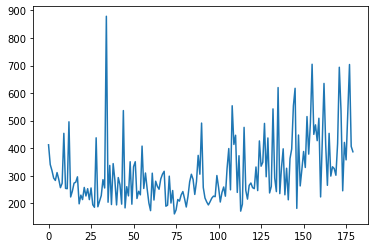

In [15]:
import matplotlib.pyplot as plt
print(type(hists['loss']))
losses = np.array([])

for loss in hists['loss']:
    losses = np.append(losses, loss)

plt.plot(losses[20:])
plt.show()
#200 epoch 6hours 

In [16]:
model_ft.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

In [17]:
# test_dir = f'{prefix}/data/test_imgs'
test_dir = os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open","test_imgs")
test_imgs = os.listdir(test_dir)

In [18]:
class TestDataset(data_utils.Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, phase, data_transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.phase = phase
        self.data_transforms = data_transforms

    def __getitem__(self, idx):
        filename = self.imgs[idx]
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))

        if self.data_transforms:
            augmented = self.data_transforms[self.phase](image=img)
            img = augmented['image']
        return filename, img
    
    def __len__(self):
        return len(self.imgs)
    
test_data = TestDataset(test_dir, test_imgs, data_transforms=A_transforms, phase='test')
test_loader = data_utils.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [19]:
all_predictions = []
files = []
with torch.no_grad():
    for filenames, inputs in test_loader:
        predictions = list(model_ft(inputs.to(device)).cpu().numpy())
        files.extend(filenames)
        for prediction in predictions:
            all_predictions.append(prediction)

In [20]:
all_predictions = np.array(all_predictions)
for i in range(all_predictions.shape[0]):
    all_predictions[i, [2*j for j in range(num_classes//2)]] /= input_w_resize / 1920
    all_predictions[i, [2*j + 1 for j in range(num_classes//2)]] /= input_h_resize / 1080

In [21]:
path = os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open","sample_submission.csv")
df_sub = pd.read_csv(path)
df = pd.DataFrame(columns=df_sub.columns)
df['image'] = files
df.iloc[:, 1:] = all_predictions
df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,1090.660278,550.783875,1080.702271,582.813782,1101.013672,580.820679,1057.661865,634.306213,1112.793091,...,1042.262085,376.866577,955.807922,548.772644,898.230835,526.669006,743.145142,672.962952,830.159912,626.949097
1,649-2-4-32-Z148_A-0000003.jpg,1091.581543,553.15448,1081.05957,585.896667,1101.384644,584.022461,1057.843506,637.368408,1113.890991,...,1044.701538,375.043671,956.311462,549.233704,898.127869,526.847717,742.279053,674.701355,832.769836,628.63739
2,649-2-4-32-Z148_A-0000005.jpg,1105.437256,506.872314,1098.759033,535.544128,1117.707031,529.610596,1077.872803,589.690613,1128.552124,...,1076.870483,375.627625,970.156311,538.196228,907.439453,531.311279,739.747559,678.104248,824.020203,631.065247
3,649-2-4-32-Z148_A-0000007.jpg,1088.336182,567.878174,1080.329956,591.788086,1100.111572,585.13501,1061.44165,626.857056,1102.927734,...,1084.661255,530.032288,959.203491,564.084412,901.66803,552.84729,738.741028,657.511841,851.673584,619.989136
4,649-2-4-32-Z148_A-0000009.jpg,1108.212891,484.309326,1103.088257,501.324554,1124.897461,495.03125,1084.216553,536.13446,1126.192383,...,1070.917725,505.191254,981.245178,519.102722,924.671387,521.298157,754.09967,663.21283,821.130371,621.531006


In [22]:
df.to_csv(os.path.join("C:\\Users\\hwanseung\\Desktop\\", "open", "1. open","efficient_crop.csv"), index=False)